In [5]:
from omegaconf import OmegaConf, DictConfig
import numpy as np
import torch
from torch import Tensor, nn
import torch.nn.functional as F
from hydra.utils import instantiate
import matplotlib.pyplot as plt
import seaborn as sns

from pytorch_classification.utils.logging import pprint_yaml
from pytorch_classification.models import load_model
from pytorch_classification.data import to_device
from pytorch_classification.utils import first

In [6]:
data_cfg = OmegaConf.load('config/data/imagenet.yaml')
pprint_yaml(OmegaConf.to_yaml(data_cfg))

val_dataset = instantiate(data_cfg.val_dataset)
val_loader = instantiate(data_cfg.val_loader)

batch_size: 256                                                                                                    
num_workers: 16                                                                                                    
root: datasets/ILSVRC-2012                                                                                         
train_dataset:                                                                                                     
  _target_: torchvision.datasets.ImageNet                                                                          
  root: ${..root}                                                                                                  
  split: train                                                                                                     
  transform:                                                                                                       
    _partial_: true                                                                                                
    _target_: pytorch_classification.transforms.imagenet.train_transform                                           
val_dataset:                                                                                                       
  _target_: torchvision.datasets.ImageNet                                                                          
  root: ${..root}                                                                                                  
  split: val                                                                                                       
  transform:                                                                                                       
    _partial_: true                                                                                                
    _target_: pytorch_classification.transforms.imagenet.val_transform                                             
train_loader:                                                                                                      
  _target_: torch.utils.data.DataLoader                                                                            
  dataset: ${..train_dataset}                                                                                      
  shuffle: true                                                                                                    
  batch_size: ${..batch_size}                                                                                      
  num_workers: ${..num_workers}                                                                                    
  pin_memory: true                                                                                                 
val_loader:                                                                                                        
  _target_: torch.utils.data.DataLoader                                                                            
  dataset: ${..val_dataset}                                                                                        
  shuffle: false                                                                                                   
  batch_size: ${..batch_size}                                                                                      
  num_workers: ${..num_workers}                                                                                    
  pin_memory: true                                                                                                 
                                                                                                                   

In [7]:
from torchvision.models import resnet50

models = {
    0: load_model(resnet50, "checkpoints/imagenet-resnet50/0.pth", torch.device("cuda")).eval(),
    1: load_model(resnet50, "checkpoints/imagenet-resnet50/1.pth", torch.device("cuda")).eval(),
}

In [8]:
batch = to_device(first(val_loader), torch.device("cuda"))

In [9]:
outs = {}
for k in models:
    model = models[k]
    with torch.no_grad():
        outs[k] = model(batch[0])


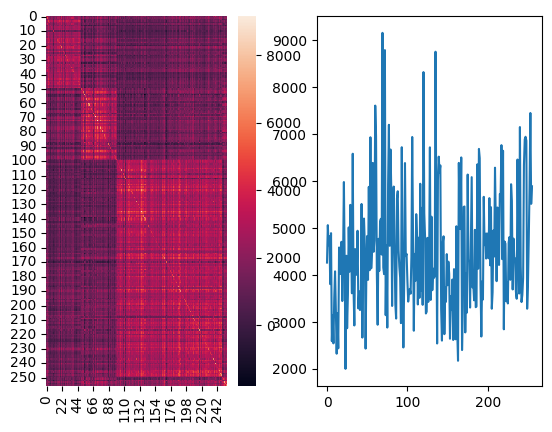

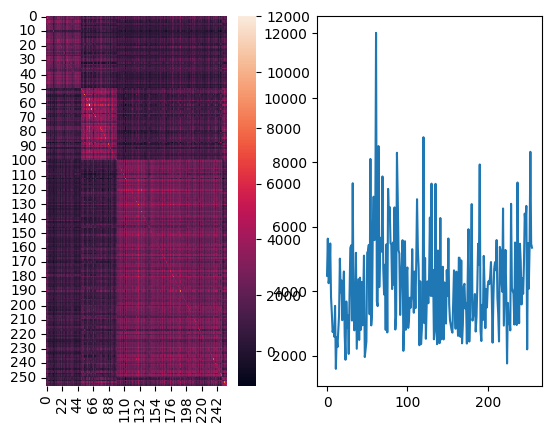

<Axes: >

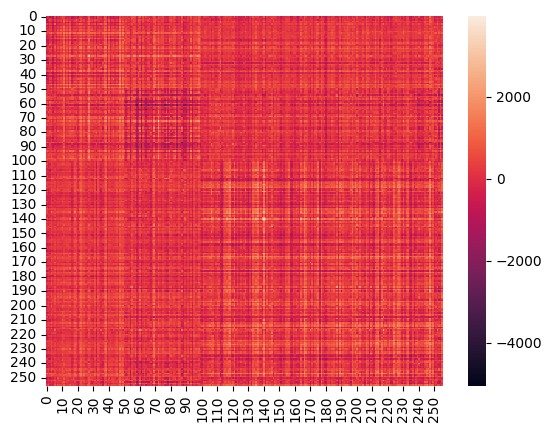

In [10]:
inner_prod = {}
for k in outs:
    with torch.no_grad():
        inner_prod[k] = outs[k] @ outs[k].T
        inner_prod[k] = inner_prod[k].cpu().numpy()

    fig, axes = plt.subplots(1, 2, squeeze=False)
    sns.heatmap(inner_prod[k], ax=axes[0][0])
    axes[0][1].plot(np.diag(inner_prod[k]))
    plt.show()

sns.heatmap(inner_prod[0] - inner_prod[1])

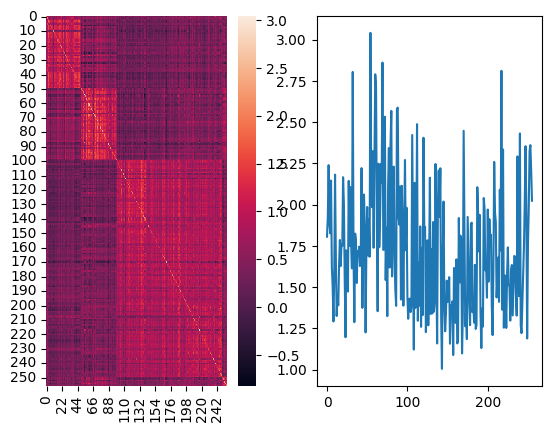

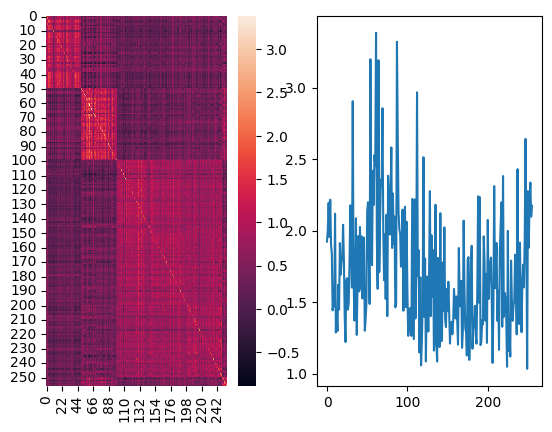

<Axes: >

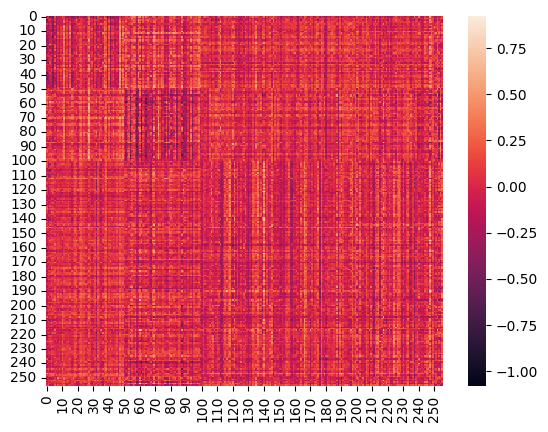

In [11]:
inner_prod = {}
for k in outs:
    with torch.no_grad():
        inner_prod[k] = F.normalize(outs[k], dim=-1) @ F.normalize(outs[k].T, dim=-1)
        inner_prod[k] = inner_prod[k].cpu().numpy()

    fig, axes = plt.subplots(1, 2, squeeze=False)
    sns.heatmap(inner_prod[k], ax=axes[0][0])
    axes[0][1].plot(np.diag(inner_prod[k]))
    plt.show()

sns.heatmap(inner_prod[0] - inner_prod[1])